## ${\textbf{Libraries}}$

In [1]:
import numpy as np
import pandas as pd
import scipy

#These are the visualization libraries. Matplotlib is standard and is what most people use.
#Seaborn works on top of matplotlib, as we mentioned in the course.
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#For standardizing features. We'll use the StandardScaler module.
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram,linkage
from sklearn.cluster import *

from sklearn.decomposition import PCA

## ${\textbf{Import Data}}$

In [2]:
df_data = pd.read_csv('CustomerDetails.csv', index_col = 0)

In [3]:
df_data.head()

DateOfBirth Gender      City  AccountBalance  HavingFD  HavingCC  \
CustomerID                                                                    
C6532335    1990-04-01      M  ABHANPUR         25025.0         0         0   
C6232347    1990-04-01      M  ABHANPUR         25025.0         1         0   
C4284828    1994-05-13      F    ABOHAR          1985.0         0         0   
C8784892    1994-05-13      F    ABOHAR          1985.0         0         0   
C5416341    1991-12-04      F    ABOHAR             3.0         0         0   

            CIBIL_Score  HavingLoan        RV  
CustomerID                                     
C6532335            775           0   51384.0  
C6232347            765           0   94271.0  
C4284828            373           0   83163.0  
C8784892            676           0    1985.0  
C5416341            513           0  149484.0

In [4]:
def data_profile(df):
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), df[col].isnull().sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 
                                            'Percentage of values in the biggest category', 'type'])
    stats_df.sort_values('Percentage of missing values', ascending=True)
    return stats_df

In [5]:
data_profile(df_data)

Feature  Unique_values  Percentage of missing values  \
0     DateOfBirth          17083                      0.000000   
1          Gender              2                      0.000000   
2            City           3086                      0.002424   
3  AccountBalance          71090                      0.000000   
4        HavingFD              2                      0.000000   
5        HavingCC              2                      0.000000   
6     CIBIL_Score            600                      0.000000   
7      HavingLoan              2                      0.000000   
8              RV         321067                      0.000000   

   Percentage of values in the biggest category     type  
0                                      0.074180   object  
1                                     72.127805   object  
2                                     15.376291   object  
3                                      0.637487  float64  
4                                     63.643433    int64  
5                                     69.550250    int64  
6                                      0.178180    int64  
7                                     55.114911    int64  
8                                      0.102736  float64

### ${\textbf{Data Cleaning}}$

In [6]:
df_data = df_data.dropna()

In [7]:
df_data.head()

DateOfBirth Gender      City  AccountBalance  HavingFD  HavingCC  \
CustomerID                                                                    
C6532335    1990-04-01      M  ABHANPUR         25025.0         0         0   
C6232347    1990-04-01      M  ABHANPUR         25025.0         1         0   
C4284828    1994-05-13      F    ABOHAR          1985.0         0         0   
C8784892    1994-05-13      F    ABOHAR          1985.0         0         0   
C5416341    1991-12-04      F    ABOHAR             3.0         0         0   

            CIBIL_Score  HavingLoan        RV  
CustomerID                                     
C6532335            775           0   51384.0  
C6232347            765           0   94271.0  
C4284828            373           0   83163.0  
C8784892            676           0    1985.0  
C5416341            513           0  149484.0

## ${\textbf{Statistics}}$

In [8]:
df_data.describe().T.style.background_gradient()

## ${\textbf{Feature Engineering}}$

In [9]:
df_data['Gender']=df_data['Gender'].map({'M':1,'F':0})

In [10]:
dates = pd.to_datetime(df_data['DateOfBirth'])
df_data['yearOfBirth'] = dates.dt.year
df_data['Age'] = 2022 - df_data['yearOfBirth']

df_data = df_data.drop(columns=['DateOfBirth','yearOfBirth'])

In [11]:
df_data.drop(df_data[(df_data['Age'] < 22 )].index, inplace=True)
df_data.drop(df_data[(df_data['Age'] > 65 )].index, inplace=True)

df_data.drop(df_data[(df_data['AccountBalance'] > 1000000)].index, inplace=True)


In [12]:
df_data.describe().T.style.background_gradient()

## ${\textbf{Correlation Estimate}}$

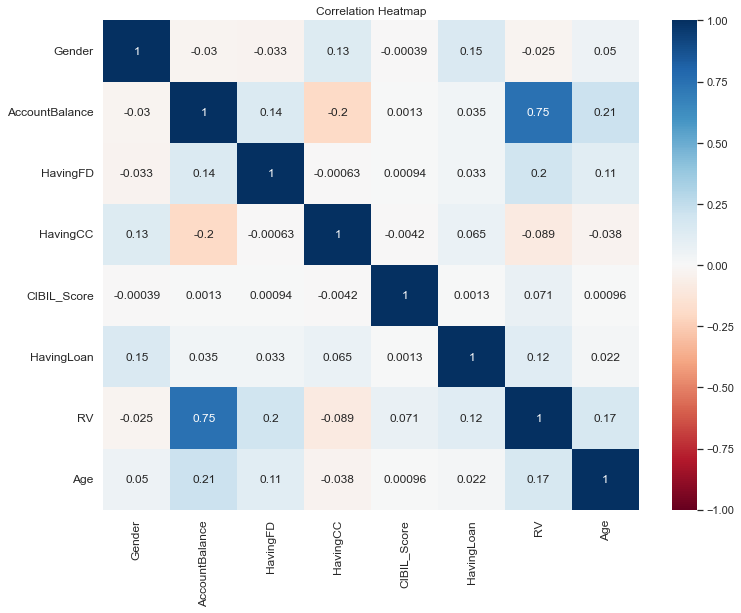

In [13]:
plt.figure(figsize = (12, 9))
s = sns.heatmap(df_data.corr(),
               annot = True, 
               cmap = 'RdBu',
               vmin = -1, 
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title('Correlation Heatmap')
plt.show()

Text(0.5, 1.0, 'Visualization of raw data')

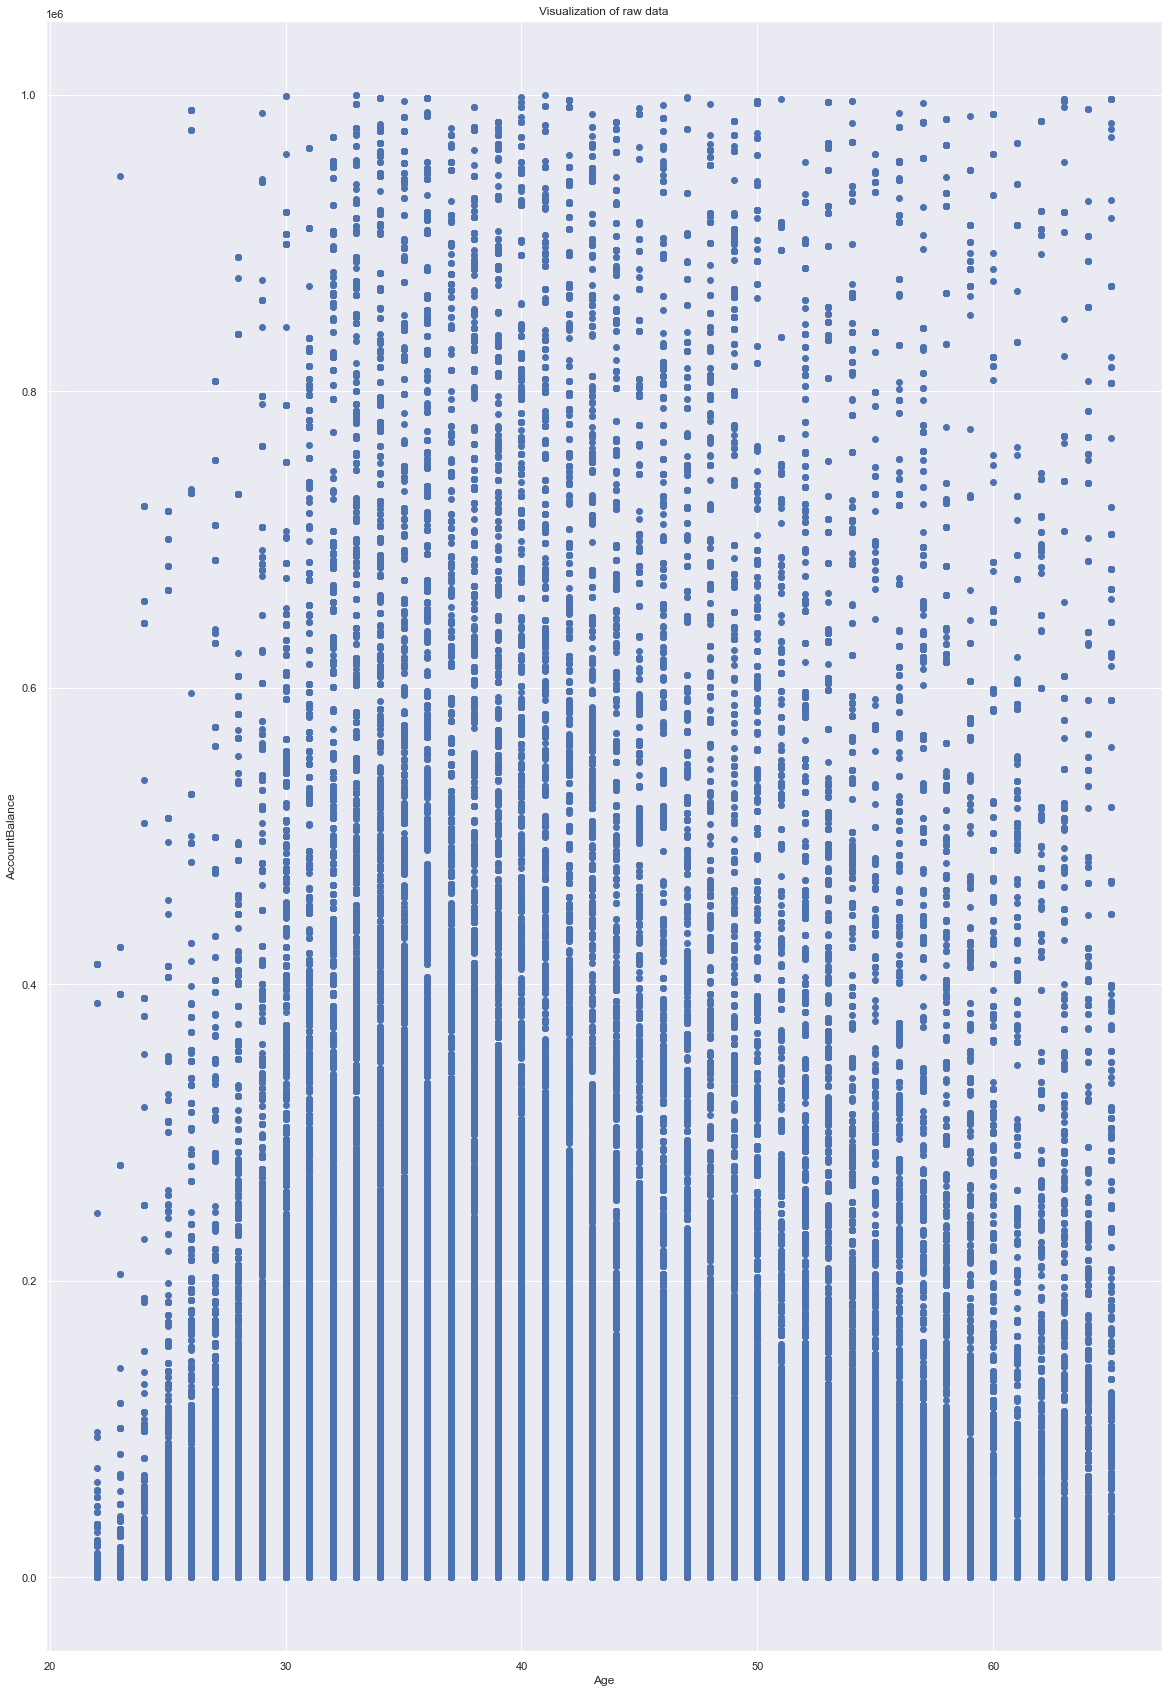

In [14]:
plt.figure(figsize = (20, 30))


plt.scatter(df_data['Age'], df_data['AccountBalance'])
plt.xlabel('Age')
plt.ylabel('AccountBalance')
plt.title('Visualization of raw data')

## ${\textbf{Standardization}}$

#### Standardizing data, so that all features have equal weight. This is important for modelling.


In [15]:
df_data_std = df_data.copy()
df_data_std = df_data_std.drop(columns=['City'])
scaler = StandardScaler()
df_data_std = scaler.fit_transform(df_data_std)

## K-means Clustering

In [16]:
wcss =[]

for i in range(1,11):
    kmeans = KMeans(n_clusters = i , init = 'k-means++', random_state = 42)
    kmeans.fit(df_data_std)
    wcss.append(kmeans.inertia_)

#### Plot the Within Cluster Sum of Squares for the different number of clusters.From this plot we choose the number of clusters.We look for a kink in the graphic, after which the descent of wcss isn't as pronounced.

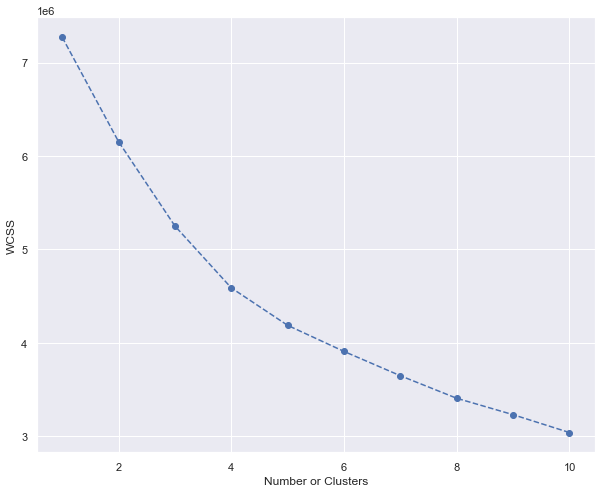

In [17]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11) , wcss , marker = 'o' , linestyle = '--')
plt.xlabel('Number or Clusters')
plt.ylabel('WCSS')
plt.show()

In [18]:
kmeans = KMeans(n_clusters = 4 , init = 'k-means++', random_state = 42)

In [19]:
kmeans.fit(df_data_std)

KMeans(n_clusters=4, random_state=42)

### Results 

In [20]:
df_data_kmeans = df_data.copy()
df_data_kmeans['Seagment K-means'] = kmeans.labels_

In [21]:
df_data_analysis = df_data_kmeans.groupby(['Seagment K-means']).mean()

In [22]:
df_data_analysis

Gender  AccountBalance  HavingFD  HavingCC  CIBIL_Score  \
Seagment K-means                                                              
0                 0.000000    39360.296633  0.372224  0.229018   599.623935   
1                 1.000000    19843.276557  0.326730  1.000000   598.692892   
2                 0.713567   462115.360963  0.551804  0.000000   603.160692   
3                 1.000000    39128.544788  0.340713  0.000000   599.956674   

                  HavingLoan             RV        Age  
Seagment K-means                                        
0                   0.317068  135304.710330  35.454191  
1                   0.498863  132687.781914  36.026892  
2                   0.501492  547555.096396  41.714026  
3                   0.498336  125329.164283  36.430848

In [23]:
df_data_analysis['N Obs'] = df_data_kmeans[['Seagment K-means' ,'Gender']].groupby(['Seagment K-means']).count()

In [24]:
df_data_analysis['Prop obs'] = df_data_analysis['N Obs'] / df_data_analysis['N Obs'].sum()

In [25]:
df_data_analysis

Gender  AccountBalance  HavingFD  HavingCC  CIBIL_Score  \
Seagment K-means                                                              
0                 0.000000    39360.296633  0.372224  0.229018   599.623935   
1                 1.000000    19843.276557  0.326730  1.000000   598.692892   
2                 0.713567   462115.360963  0.551804  0.000000   603.160692   
3                 1.000000    39128.544788  0.340713  0.000000   599.956674   

                  HavingLoan             RV        Age   N Obs  Prop obs  
Seagment K-means                                                          
0                   0.317068  135304.710330  35.454191  238706  0.262617  
1                   0.498863  132687.781914  36.026892  231739  0.254952  
2                   0.501492  547555.096396  41.714026   52274  0.057510  
3                   0.498336  125329.164283  36.430848  386231  0.424920

#### Understanding the clustering well ... 
##### A fixed deposit (FD) is a financial instrument provided by banks or NBFCs which provides investors a higher rate of interest than a regular savings account, until the given maturity date. It may or may not require the creation of a separate account. 
##### A secured credit card (CC)is a credit card variant that can be availed against a fixed deposit (FD) with the bank or card issuer. Each bank specifies a minimum fixed deposit amount to apply for a secured credit card. The amount in your FD account is directly linked to the total credit limit on your credit card. This means, the higher your FD amount is, the higher would be your credit card limit. Banks typically provide 75% to 85% of the FD amount as the credit card limit.
##### Lies (CIBIL_Score) between 300-900 and signifies the customer's creditworthiness.
##### RV Total quantitative relationship values with the bank. Including all (AccountBalance, FD, Credit Card, Loan)`

In [26]:
df_data_analysis.rename({0:'Fmale invest well',
                         1:'Male with high loans and low AB',
                         2:'Financially stable',
                         3:'Male with high loans and high AB'})

Gender  AccountBalance  HavingFD  \
Seagment K-means                                                       
Fmale invest well                 0.000000    39360.296633  0.372224   
Male with high loans and low AB   1.000000    19843.276557  0.326730   
Financially stable                0.713567   462115.360963  0.551804   
Male with high loans and high AB  1.000000    39128.544788  0.340713   

                                  HavingCC  CIBIL_Score  HavingLoan  \
Seagment K-means                                                      
Fmale invest well                 0.229018   599.623935    0.317068   
Male with high loans and low AB   1.000000   598.692892    0.498863   
Financially stable                0.000000   603.160692    0.501492   
Male with high loans and high AB  0.000000   599.956674    0.498336   

                                             RV        Age   N Obs  Prop obs  
Seagment K-means                                                              
Fmale invest well                 135304.710330  35.454191  238706  0.262617  
Male with high loans and low AB   132687.781914  36.026892  231739  0.254952  
Financially stable                547555.096396  41.714026   52274  0.057510  
Male with high loans and high AB  125329.164283  36.430848  386231  0.424920

In [27]:
df_data_kmeans['Labels'] = df_data_kmeans['Seagment K-means'].map({0:'Fmale invest well',
                                                                    1:'Male with high loans and low AB',
                                                                    2:'Financially stable',
                                                                    3:'Male with high loans and high AB'})  

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\frnsa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


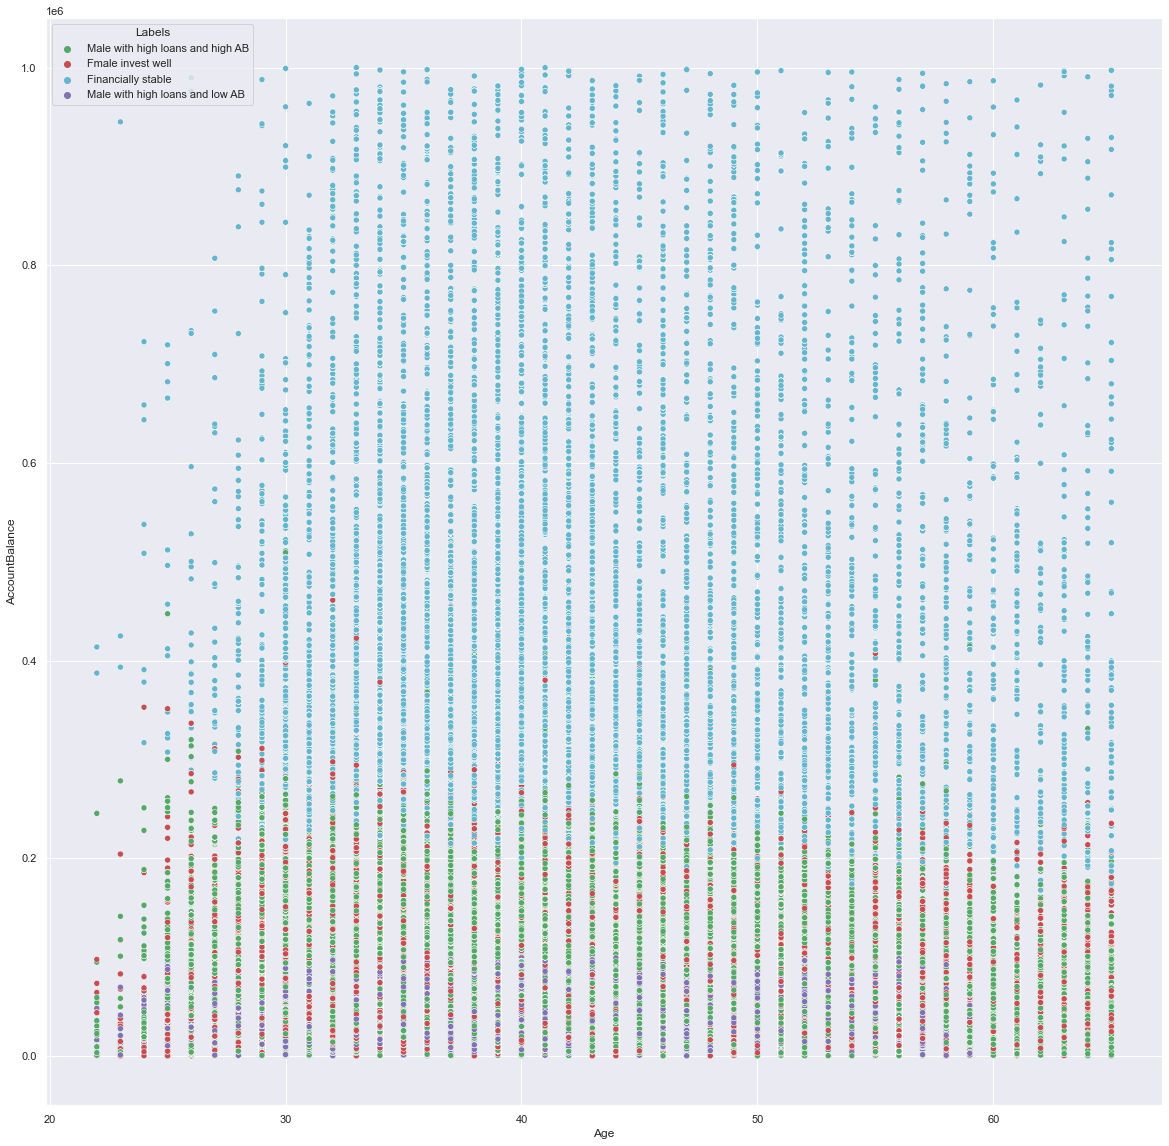

In [28]:
x_axis = df_data_kmeans['Age']
y_axis = df_data_kmeans['AccountBalance']
plt.figure(figsize = (20,20))
sns.scatterplot(x_axis,y_axis,hue = df_data_kmeans['Labels'],palette=['g','r','c','m'])
plt.show()

## PCA

In [29]:
pca = PCA()

In [30]:
pca.fit(df_data_std)

PCA()

In [31]:
pca.explained_variance_ratio_

array([0.24567362, 0.15573804, 0.12590711, 0.12144809, 0.11595822,
       0.10694686, 0.09892322, 0.02940482])

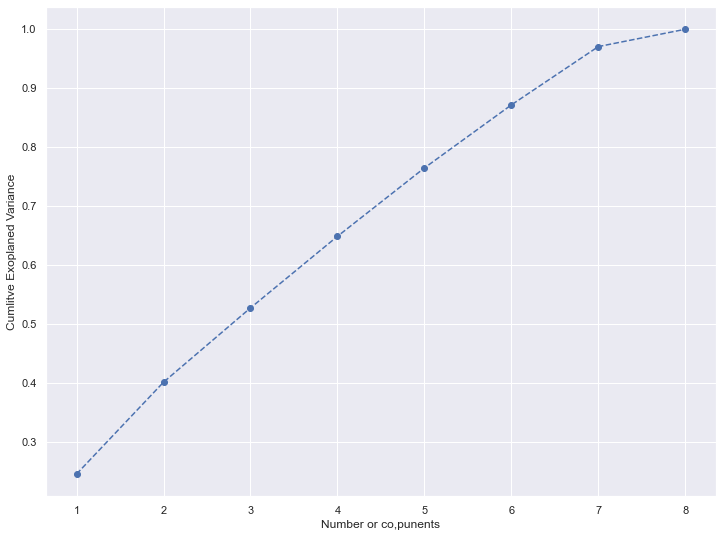

In [32]:
plt.figure(figsize = (12,9))
plt.plot(range(1,9) , pca.explained_variance_ratio_.cumsum() , marker ='o' , linestyle='--')
plt.xlabel('Number or co,punents')
plt.ylabel('Cumlitve Exoplaned Variance')
plt.show()

In [33]:
pca = PCA(n_components = 5)

In [34]:
pca.fit(df_data_std)

PCA(n_components=5)

## PCA results

In [35]:
pca.components_

array([[-0.04283816,  0.63412107,  0.26186301, -0.19960745,  0.04834317,
         0.09556771,  0.62805185,  0.28586818],
       [ 0.63752014, -0.04339092,  0.07512154,  0.48708084,  0.01105999,
         0.57020101,  0.05861896,  0.14179778],
       [ 0.00791156,  0.00970575, -0.21981833, -0.02209393,  0.93837551,
         0.06991189,  0.09985564, -0.23585491],
       [ 0.19664016,  0.18474506, -0.72365984, -0.40421409, -0.27934659,
         0.29466284,  0.09410528, -0.25770684],
       [ 0.32916571, -0.02877692, -0.32912868, -0.15699567,  0.15168094,
        -0.36742451, -0.16168363,  0.75742922]])

In [36]:
df_data_pca_comp = pd.DataFrame(data = pca.components_ ,
                          columns = df_data.drop(columns=['City']).columns.values,
                          index = ['Comp1','Comp2' ,'Comp3','Comp4','Comp5'])
df_data_pca_comp

Gender  AccountBalance  HavingFD  HavingCC  CIBIL_Score  HavingLoan  \
Comp1 -0.042838        0.634121  0.261863 -0.199607     0.048343    0.095568   
Comp2  0.637520       -0.043391  0.075122  0.487081     0.011060    0.570201   
Comp3  0.007912        0.009706 -0.219818 -0.022094     0.938376    0.069912   
Comp4  0.196640        0.184745 -0.723660 -0.404214    -0.279347    0.294663   
Comp5  0.329166       -0.028777 -0.329129 -0.156996     0.151681   -0.367425   

             RV       Age  
Comp1  0.628052  0.285868  
Comp2  0.058619  0.141798  
Comp3  0.099856 -0.235855  
Comp4  0.094105 -0.257707  
Comp5 -0.161684  0.757429

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 [Text(0.5, 0, 'Gender'),
  Text(1.5, 0, 'AccountBalance'),
  Text(2.5, 0, 'HavingFD'),
  Text(3.5, 0, 'HavingCC'),
  Text(4.5, 0, 'CIBIL_Score'),
  Text(5.5, 0, 'HavingLoan'),
  Text(6.5, 0, 'RV'),
  Text(7.5, 0, 'Age')])

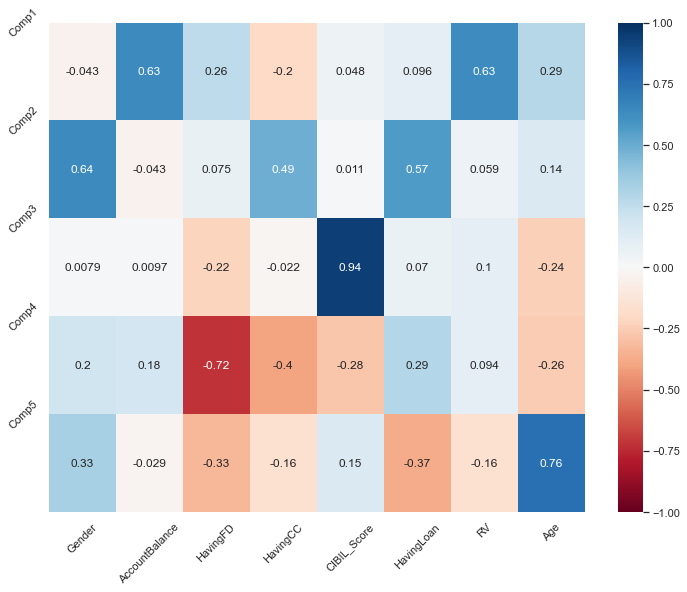

In [37]:
plt.figure(figsize = (12, 9))
sns.heatmap(df_data_pca_comp,
           vmin= -1,
           vmax = 1,
           cmap ='RdBu',
           annot=True)

plt.yticks([0,1,2,3,4],
          ['Comp1','Comp2' ,'Comp3','Comp4','Comp5'],
          rotation = 45)
plt.xticks(rotation = 45
          )

In [38]:
pca.transform(df_data_std)

array([[-0.9297497 , -0.61059425,  1.1327472 ,  0.41946263,  0.72179357],
       [-0.19321189, -0.43648474,  0.65065466, -1.04539157, -0.0233431 ],
       [-1.0774645 , -2.11274652, -0.91244438,  0.75497704, -0.80507164],
       ...,
       [ 0.18316492,  0.71330193,  0.26829923, -0.20707001, -1.03515708],
       [-0.14943248, -0.45040619, -0.56027891, -0.61529669, -0.37798242],
       [-0.10379253,  0.68463025, -0.0457663 , -0.16740477, -1.00862309]])

In [39]:
scoures_pca = pca.transform(df_data_std)

## K-means clustring with PCA

In [40]:
wcss =[]

for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i , init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scoures_pca)
    wcss.append(kmeans_pca.inertia_)

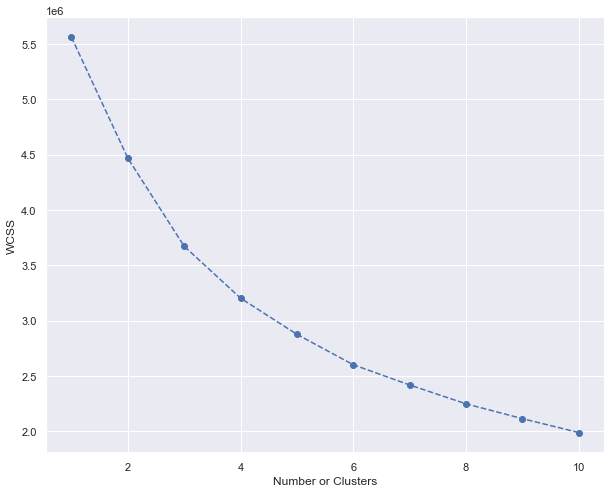

In [41]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11) , wcss , marker = 'o' , linestyle = '--')
plt.xlabel('Number or Clusters')
plt.ylabel('WCSS')
plt.show()

In [42]:
kmeans_pca = KMeans(n_clusters = 4 , init='k-means++' , random_state = 42)

In [44]:
kmeans_pca.fit(scoures_pca)

KMeans(n_clusters=4, random_state=42)

### ${\textbf{K-means clustering with PCA Results}}$

In [55]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_data_pca_kmeans = pd.concat([df_data.reset_index(drop = True), pd.DataFrame(scoures_pca)], axis = 1)
df_data_pca_kmeans.columns.values[-5: ] = ['Comp1','Comp2' ,'Comp3','Comp4','Comp5']
# The last column we add contains the pca k-means clustering labels.
df_data_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [56]:
df_data_pca_kmeans

Gender        City  AccountBalance  HavingFD  HavingCC  CIBIL_Score  \
0            1    ABHANPUR         25025.0         0         0          775   
1            1    ABHANPUR         25025.0         1         0          765   
2            0      ABOHAR          1985.0         0         0          373   
3            0      ABOHAR          1985.0         0         0          676   
4            0      ABOHAR             3.0         0         0          513   
...        ...         ...             ...       ...       ...          ...   
908945       1     ZIRKPUR         35142.0         1         0          427   
908946       1  ZUARINAGAR         17339.0         1         0          426   
908947       1  ZUARINAGAR         17339.0         1         0          654   
908948       1  ZUARINAGAR         17339.0         1         0          530   
908949       1  ZUARINAGAR         17339.0         1         0          604   

        HavingLoan        RV  Age     Comp1     Comp2     Comp3     Comp4  \
0                0   51384.0   32 -0.929750 -0.610594  1.132747  0.419463   
1                0   94271.0   32 -0.193212 -0.436485  0.650655 -1.045392   
2                0   83163.0   28 -1.077464 -2.112747 -0.912444  0.754977   
3                0    1985.0   28 -1.358210 -2.127505  0.669674  0.211979   
4                0  149484.0   31 -0.634270 -2.017710 -0.203040  0.466498   
...            ...       ...  ...       ...       ...       ...       ...   
908945           1   95666.0   47  0.543409  0.972610 -1.515323 -0.415306   
908946           1  109400.0   31 -0.106127  0.677689 -1.001789  0.126522   
908947           1  159565.0   31  0.183165  0.713302  0.268299 -0.207070   
908948           0  136015.0   31 -0.149432 -0.450406 -0.560279 -0.615297   
908949           1   98886.0   31 -0.103793  0.684630 -0.045766 -0.167405   

           Comp5  Segment K-means PCA  
0       0.721794                    3  
1      -0.023343                    0  
2      -0.805072                    3  
3      -0.445921                    3  
4      -0.451511                    3  
...          ...                  ...  
908945  0.475587                    0  
908946 -1.176551                    0  
908947 -1.035157                    0  
908948 -0.377982                    0  
908949 -1.008623                    0  

[908950 rows x 15 columns]

In [57]:
df_data_pca_kmeans_freq = df_data_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_data_pca_kmeans_freq

Gender  AccountBalance  HavingFD  HavingCC  \
Segment K-means PCA                                                 
0                    0.692831    45712.666091  0.978413  0.367753   
1                    0.965365    21485.241987  0.007007  0.565939   
2                    0.697977   436079.803187  0.536257  0.000000   
3                    0.485626    31130.568998  0.011069  0.046478   

                     CIBIL_Score  HavingLoan             RV        Age  \
Segment K-means PCA                                                      
0                     596.352848    0.473417  157725.090674  37.192328   
1                     601.527281    0.736100  125400.874633  35.502613   
2                     607.234682    0.537981  529640.384125  41.870217   
3                     599.872803    0.089766   99192.290965  35.217077   

                        Comp1     Comp2     Comp3     Comp4     Comp5  
Segment K-means PCA                                                    
0                    0.303724  0.159794 -0.327399 -1.022351 -0.401648  
1                   -0.622643  0.866624  0.207296  0.539147  0.079002  
2                    4.112298 -0.105602  0.108700  0.665188 -0.051345  
3                   -0.554983 -1.119884  0.113039  0.401465  0.374344

In [58]:
df_data_pca_kmeans_freq['N Obs'] = df_data_pca_kmeans[['Segment K-means PCA','Age']].groupby(['Segment K-means PCA']).count()
df_data_pca_kmeans_freq['Prop Obs'] = df_data_pca_kmeans_freq['N Obs'] / df_data_pca_kmeans_freq['N Obs'].sum()
df_data_pca_kmeans_freq = df_data_pca_kmeans_freq.rename({0:'Good invstores', 
                                                          1:'High speending',
                                                          2:'well-off', 
                                                          3:'Standered'})
df_data_pca_kmeans_freq



Gender  AccountBalance  HavingFD  HavingCC  \
Segment K-means PCA                                                 
Good invstores       0.692831    45712.666091  0.978413  0.367753   
High speending       0.965365    21485.241987  0.007007  0.565939   
well-off             0.697977   436079.803187  0.536257  0.000000   
Standered            0.485626    31130.568998  0.011069  0.046478   

                     CIBIL_Score  HavingLoan             RV        Age  \
Segment K-means PCA                                                      
Good invstores        596.352848    0.473417  157725.090674  37.192328   
High speending        601.527281    0.736100  125400.874633  35.502613   
well-off              607.234682    0.537981  529640.384125  41.870217   
Standered             599.872803    0.089766   99192.290965  35.217077   

                        Comp1     Comp2     Comp3     Comp4     Comp5   N Obs  \
Segment K-means PCA                                                             
Good invstores       0.303724  0.159794 -0.327399 -1.022351 -0.401648  295323   
High speending      -0.622643  0.866624  0.207296  0.539147  0.079002  292565   
well-off             4.112298 -0.105602  0.108700  0.665188 -0.051345   57989   
Standered           -0.554983 -1.119884  0.113039  0.401465  0.374344  263073   

                     Prop Obs  
Segment K-means PCA            
Good invstores       0.324906  
High speending       0.321871  
well-off             0.063798  
Standered            0.289425

In [59]:
df_data_pca_kmeans['Legend'] = df_data_pca_kmeans['Segment K-means PCA'].map({0:'Good Invstores', 
                                                                              1:'High speending',
                                                                              2:'well-off', 
                                                                              3:'Standered'})

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


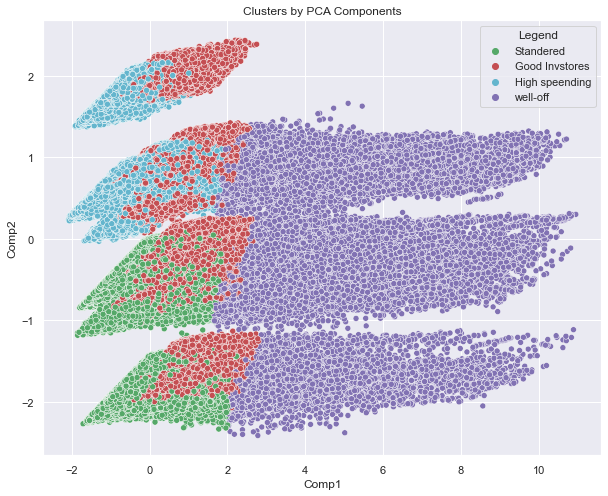

In [60]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp1']
y_axis = df_data_pca_kmeans['Comp2']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\frnsa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


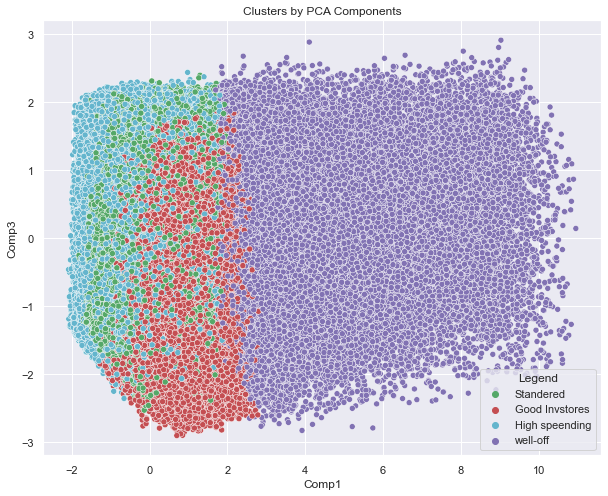

In [61]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp1']
y_axis = df_data_pca_kmeans['Comp3']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


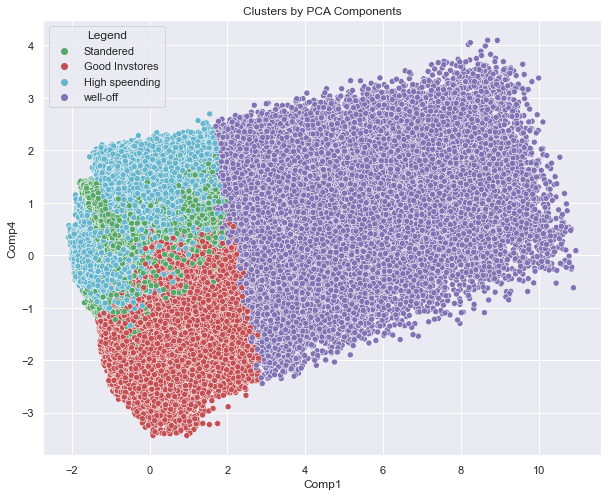

In [62]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp1']
y_axis = df_data_pca_kmeans['Comp4']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


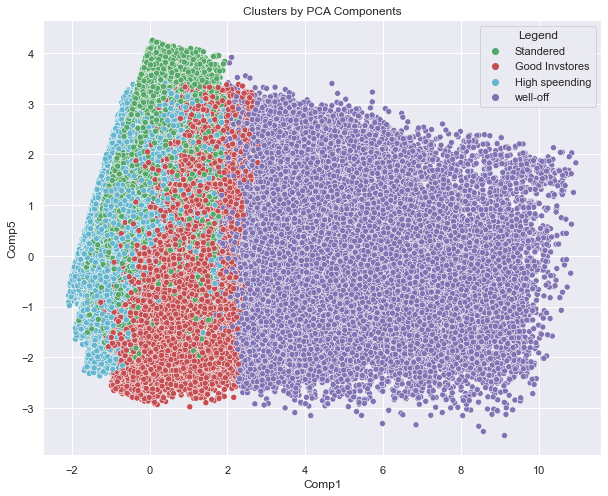

In [63]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp1']
y_axis = df_data_pca_kmeans['Comp5']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\frnsa\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


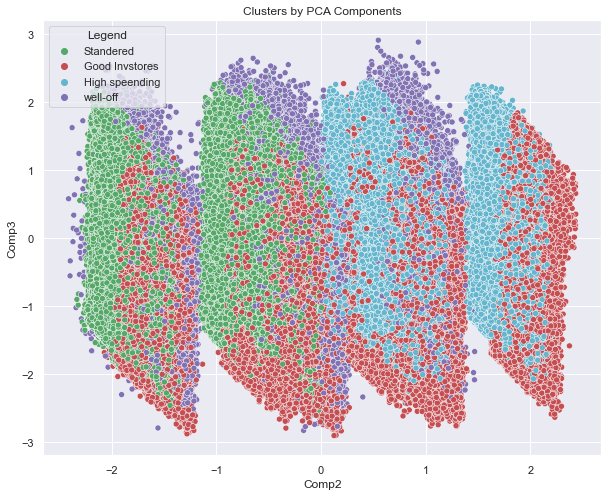

In [64]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp2']
y_axis = df_data_pca_kmeans['Comp3']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


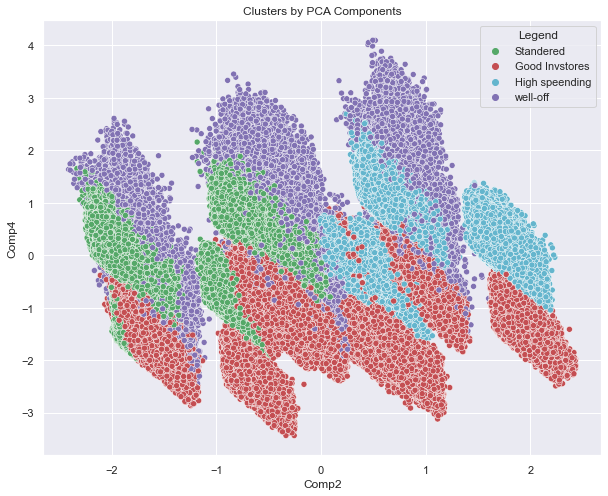

In [65]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp2']
y_axis = df_data_pca_kmeans['Comp4']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


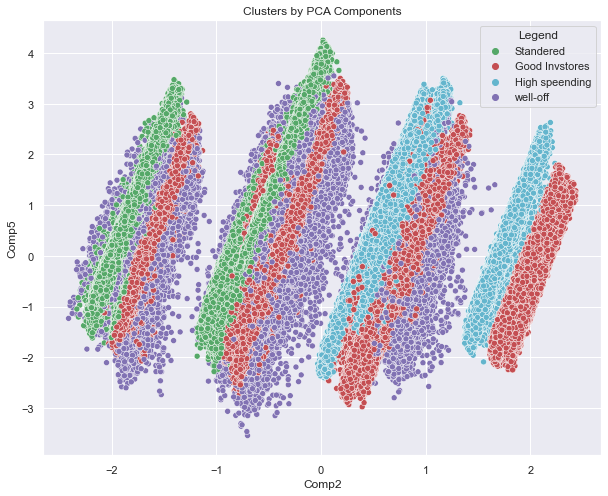

In [66]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp2']
y_axis = df_data_pca_kmeans['Comp5']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


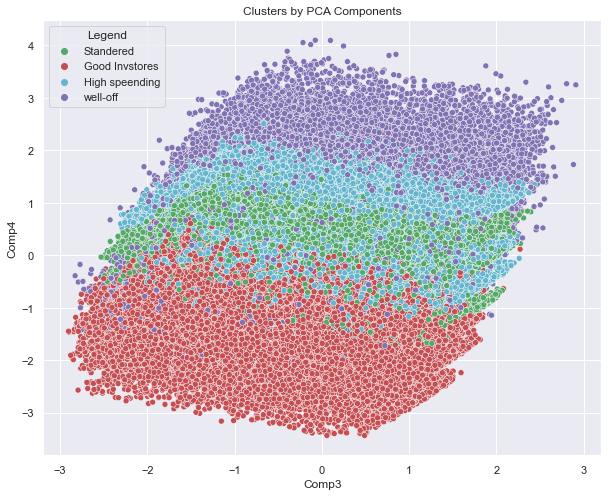

In [67]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp3']
y_axis = df_data_pca_kmeans['Comp4']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


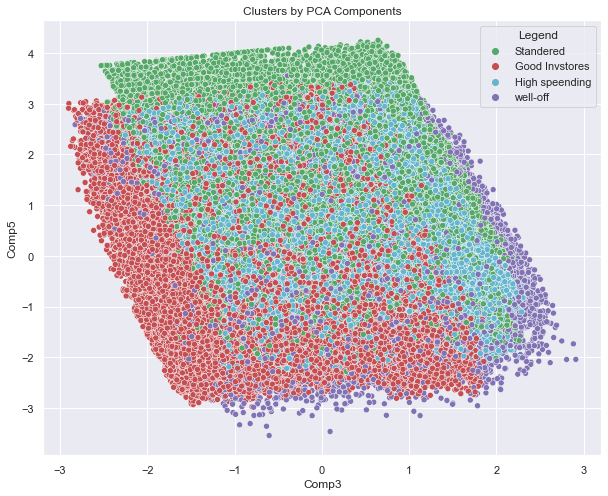

In [68]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp3']
y_axis = df_data_pca_kmeans['Comp5']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()

C:\Users\frnsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


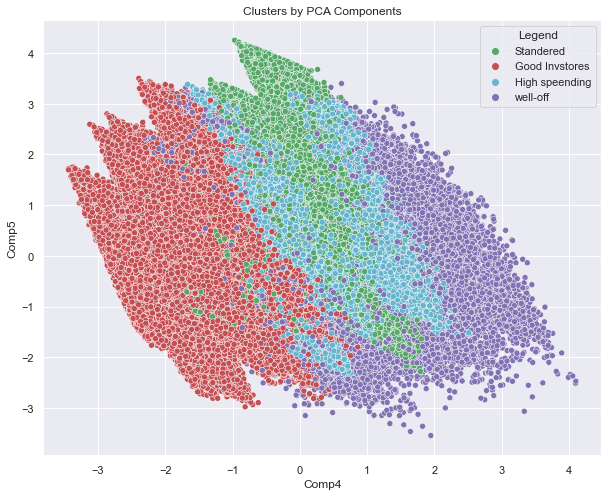

In [69]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_data_pca_kmeans['Comp4']
y_axis = df_data_pca_kmeans['Comp5']
plt.figure(figsize = (10, 8))
sns.scatterplot(x_axis, y_axis, hue = df_data_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()